# Entrega 2 - Grupo 12

*Introducción a la Minería de Datos*

Pedro Belmonte,
Jorge Fabry,
Víctor Garrido,
Pablo Ilabaca


# Introducción

Para esta entrega, ahondamos en el trabajo realizado anteriormente. En la primera parte hacemos todo un manejo de datos para convertir el dataset en tablas utilizables por los clasificadores. Luego, se utilizan distintos clasificadores y técnicas de balanceo de clases para buscar un modelo que permita predecir si un juego será o no una decepción.

# 1 - Importación de Data Set
El dataset original es extraido de https://www.kaggle.com/silver1996/videogames/data. En una primera instancia, se utilizó el siguiente Script de R para filtrar el dataset.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import io
import pydotplus
import imageio

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  # support vector machine classifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
data = pd.read_csv('data/data_para_clasificadores.csv',encoding='latin1')
data.head()

## Se tienen 8 columnas. La primera un número por cada juego. Las siguientes 6 son parámetros, y la última la clase del juego.
## La clase corresponde a si el juego es un fiasco o no.

,Unnamed: 0,Platform,Genre,Publisher,Global_Sales,Critic_Score,Rating,Is_Fiasco
0,1,X360,Misc,Microsoft Game Studios,21.81,61,E,False
1,2,PS3,Action,Take-Two Interactive,21.04,97,M,False
2,3,PS2,Action,Take-Two Interactive,20.81,95,M,False
3,4,X360,Action,Take-Two Interactive,16.27,97,M,False
4,5,PS2,Action,Take-Two Interactive,16.15,95,M,False


Cabe notar que las clases **no** están balanceadas.

In [2]:
print("Cantidad de Fiascos")
data['Is_Fiasco'].value_counts()

Cantidad de Fiascos


False    2169
True      179
Name: Is_Fiasco, dtype: int64

# 2 - Adaptando el Data Set
Los clasificadores no pueden trabajar con Strings directamente. Vemos que Platform, Genre, Publisher y Rating son categorías que utilizan Strings, y hay que aplicar algún tipo de transformación para poder alimentarlas al clasificador.

Para esto, se utiliza un LabelBinarizer, que permite covertir las distintas categorías de una columna en columnas independientes. El resultado final es una matriz de dimensiones: 2348 rows x 34 columns.

In [3]:
from sklearn import preprocessing

## Se aplica LabelBinarizer columna por columna, y finalmente se unen los resultados
## En header se van guardando los nombres de cada columna para luego agregarlas al nuevo Data Set
lb = preprocessing.LabelBinarizer()

lb.fit(data["Platform"])
platform = lb.transform(data["Platform"])
header = lb.classes_

lb.fit(data["Genre"])
genre = lb.transform(data["Genre"])
header = np.append(header,lb.classes_)

lb.fit(data["Publisher"])
publisher = lb.transform(data["Publisher"])
header = np.append(header,lb.classes_)

##sales = np.transpose(np.matrix(data["Global_Sales"].values))
##header = np.append(header,"Global_Sales")

critic_score = np.transpose(np.matrix(data["Critic_Score"].values))
header = np.append(header,"Critic_Score")

lb.fit(data["Rating"])
rating = lb.transform(data["Rating"])
header = np.append(header,lb.classes_)

fiasco = np.transpose(np.matrix(data["Is_Fiasco"].values))
header = np.append(header,"Is_Fiasco")

new_matrix = np.hstack((platform,genre,publisher,critic_score,rating,fiasco))
new_data = pd.DataFrame(new_matrix)
new_data.columns = header

## Se separa los datos de los resultados a predecir.
X = new_data[new_data.columns[:-1]]
y = new_data[new_data.columns[-1]]

Para observar la nueva data:

In [4]:
new_data

,PC,PS2,PS3,X360,XB,Action,Adventure,Fighting,Misc,Platform,...,THQ,Take-Two Interactive,Ubisoft,Critic_Score,AO,E,E10+,M,T,Is_Fiasco
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,61,0,1,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,95,0,1,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,88,0,0,0,1,0,1
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,87,0,0,0,1,0,1
8,0,0,1,0,0,0,0,0,0,0,...,0,0,0,83,0,0,0,1,0,1
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,83,0,0,0,1,0,1


# 3 - Comparando clasificadores
A continuación, utilizando código del lab 2.2, se comparan distintos clasificadores mediante el contraste de las métricas obtenidas luego de un buen número de pruebas.

In [5]:

def run_classifier(clf, X, y, num_tests=100):
    metrics = {'f1-score': [], 'precision': [], 'recall': []}
    
    for _ in range(num_tests):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)        
        
        metrics['f1-score'].append(f1_score(y_test,predictions))  # X_test y y_test deben ser definidos previamente
        metrics['recall'].append(recall_score(y_test,predictions))
        metrics['precision'].append(precision_score(y_test,predictions))
    
    return metrics

In [6]:


def run_many_classifiers(X, y, num_test):
    c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
    c1 = ("Decision Tree", DecisionTreeClassifier(min_samples_split=100))
    c2 = ("Gaussian Naive Bayes", GaussianNB())
    c3 = ("KNN-3", KNeighborsClassifier(n_neighbors=3))
    c4 = ("KNN-5", KNeighborsClassifier(n_neighbors=5))

    classifiers = [c0, c1, c2, c3, c4]
    print("Corriendo "+ str(num_test) + " tests por clasificador\n")

    for name, clf in classifiers:
        metrics = run_classifier(clf, X, y, num_test)
        print("----------------")
        print("Resultados para clasificador: ",name) 
        print("Precision promedio:",np.array(metrics['precision']).mean())
        print("Recall promedio:",np.array(metrics['recall']).mean())
        print("F1-score promedio:",np.array(metrics['f1-score']).mean())
        print("----------------\n")
        
run_many_classifiers(X, y, 10)

Corriendo 10 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.06328304465994436
Recall promedio: 0.06481481481481481
F1-score promedio: 0.063806779487772
----------------



/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.24896367521367518
Recall promedio: 0.05
F1-score promedio: 0.08258513977730396
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.09906949285017805
Recall promedio: 0.8777777777777777
F1-score promedio: 0.17787620885207892
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.22575595457174402
Recall promedio: 0.09074074074074073
F1-score promedio: 0.12772974486255478
----------------

----------------
Resultados para clasificador:  KNN-5
Precision promedio: 0.21283910533910536
Recall promedio: 0.037037037037037035
F1-score promedio: 0.062261458679760164
----------------



# 4 - Utilizando Subsampling y Oversampling
En un intento de encontrar mejores resultados que los anteriores, se aplicarán estas estrategias sobre el dataset.
Nuevamente nos apoyamos en código trabajado en el laboratorio 2.2.

In [7]:
# oversampling sobre la clase True
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=1990)
data_oversampled = pd.concat([new_data, new_data.iloc[idx]])

print("Data oversampled on class 'True'")
print(data_oversampled['Is_Fiasco'].value_counts())
print()

# subsampling sobre la clase False
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1990, replace=False)
data_subsampled = new_data.drop(new_data.iloc[idx].index)

print("Data subsampled on class 'False'")
print(data_subsampled['Is_Fiasco'].value_counts())

Data oversampled on class 'True'
1    2169
0    2169
Name: Is_Fiasco, dtype: int64

Data subsampled on class 'False'
1    179
0    179
Name: Is_Fiasco, dtype: int64


In [8]:
# datos "oversampleados" 
X_over = data_oversampled[new_data.columns[:-1]]
y_over = data_oversampled[new_data.columns[-1]]

# datos "subsampleados"
X_subs = data_subsampled[new_data.columns[:-1]]
y_subs = data_subsampled[new_data.columns[-1]]

print("----------Prueba Oversampling------------")
run_many_classifiers(X_over, y_over, 10)


print("\n\n----------Prueba Subsampling------------")
run_many_classifiers(X_subs, y_subs, 10)

----------Prueba Oversampling------------
Corriendo 10 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.5047329638280671
Recall promedio: 0.5056835637480799
F1-score promedio: 0.5051225718573428
----------------

----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.7783266661679612
Recall promedio: 0.8384024577572964
F1-score promedio: 0.806944611626558
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.5679681223682443
Recall promedio: 0.927956989247312
F1-score promedio: 0.7044697755573243
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.830939417175897
Recall promedio: 0.9907834101382488
F1-score promedio: 0.9038256183685119
----------------

----------------
Resultados para clasificador:  KNN-5
Precision promedio: 0.7953140056319217
Recall promedio: 0.9901689708141321
F1-score promedio: 0.882077

También se aplicó una combinación de ambas cosas, para balancear las clases sin corromper demasiado la integridad de los datos.

In [9]:
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=71)
data_master = pd.concat([new_data, new_data.iloc[idx]])
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1669, replace=False)
data_master = new_data.drop(new_data.iloc[idx].index)
print("Data subsampled on class 'False' and oversampled on class 'True'")
print(data_master['Is_Fiasco'].value_counts())
X_mast = data_master[new_data.columns[:-1]]
y_mast = data_master[new_data.columns[-1]]
run_many_classifiers(X_mast, y_mast, 10)

Data subsampled on class 'False' and oversampled on class 'True'
0    500
1    179
Name: Is_Fiasco, dtype: int64
Corriendo 10 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.26403857335893743
Recall promedio: 0.27037037037037037
F1-score promedio: 0.2668648280188905
----------------



/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pedro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.3380617038738636
Recall promedio: 0.25
F1-score promedio: 0.2852424812457662
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.30345227750597925
Recall promedio: 0.8925925925925926
F1-score promedio: 0.4518787376325841
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.4050108449360225
Recall promedio: 0.32777777777777783
F1-score promedio: 0.36144945331622297
----------------

----------------
Resultados para clasificador:  KNN-5
Precision promedio: 0.3803992248724031
Recall promedio: 0.26111111111111107
F1-score promedio: 0.30885710718912274
----------------



# 5 - Graficando Decision Trees
Se grafican los árboles de decisión, donde los colores indican afinidad con una clase.

In [12]:
c12= DecisionTreeClassifier(min_samples_split=100)
c13= DecisionTreeClassifier(min_samples_split=100)
c14= DecisionTreeClassifier(min_samples_split=100)
c15= DecisionTreeClassifier(min_samples_split=100)
features=new_data.columns[:-1]
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]

dt12=c12.fit(X_train,y_train)
dt13=c13.fit(X_over,y_over)
dt14=c14.fit(X_subs,y_subs)
dt15=c15.fit(X_mast,y_mast)

def show_tree(tree, features, path):
    path = "images/" + path
    f= io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features,filled=True,rounded=True)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img= imageio.imread(path)
    plt.rcParams["figure.figsize"]=(20,20)
    plt.imshow(img)
    
#show_tree(dt12, features, 'arbol_normal.png')
#show_tree(dt13, features, 'arbol_oversampled.png')
#show_tree(dt14, features, 'arbol_subsampled.png')
#show_tree(dt15, features, 'arbol_master.png')

Árbol Normal:

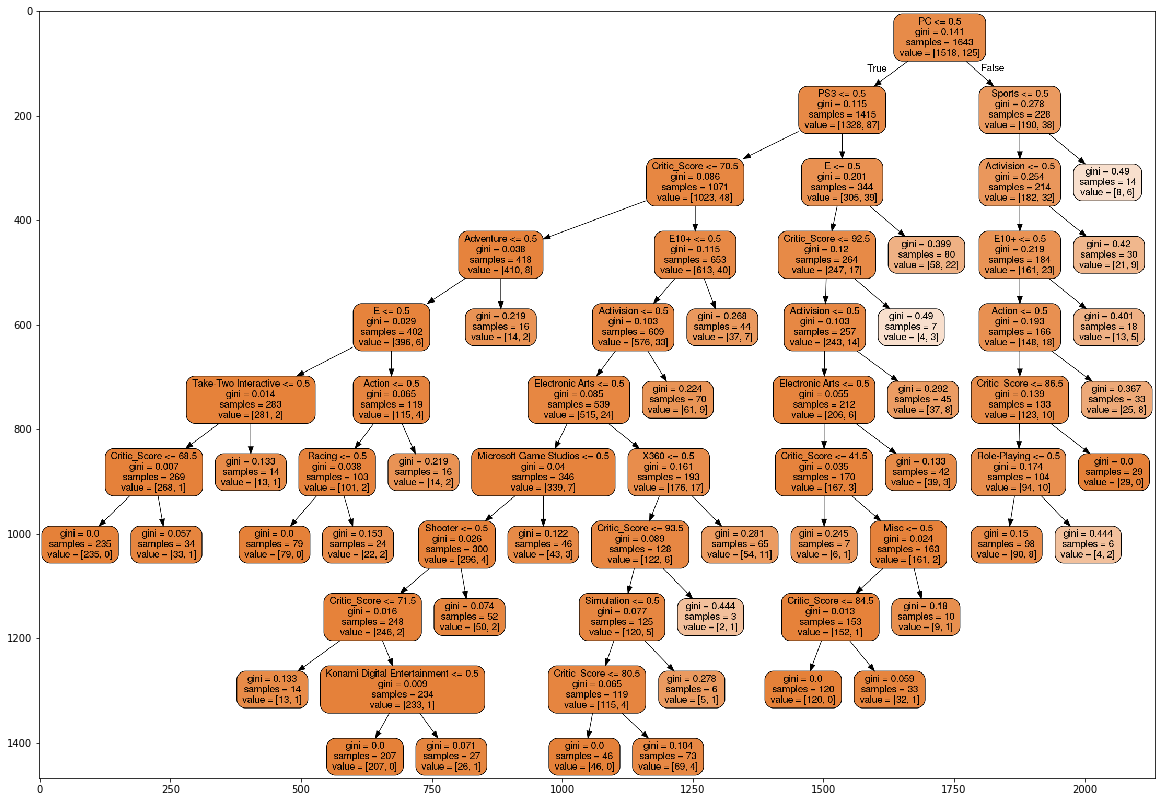

In [13]:
show_tree(dt12, features, 'arbol_normal.png')

Árbol Oversampled:

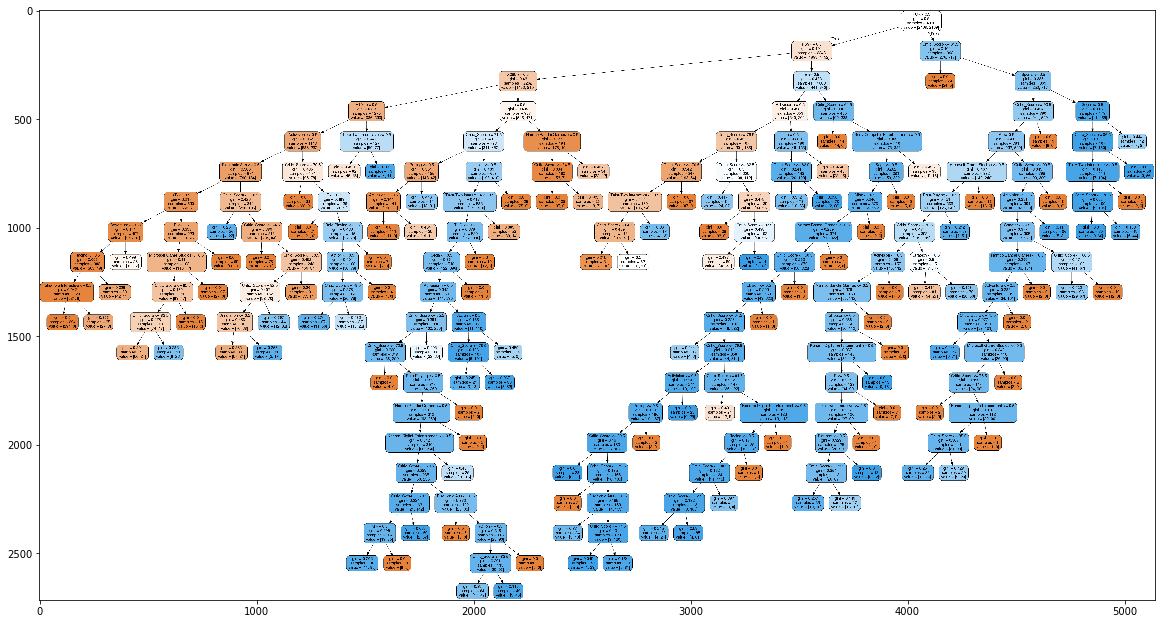

In [14]:
show_tree(dt13, features, 'arbol_oversampled.png')

Árbol Subsampled:

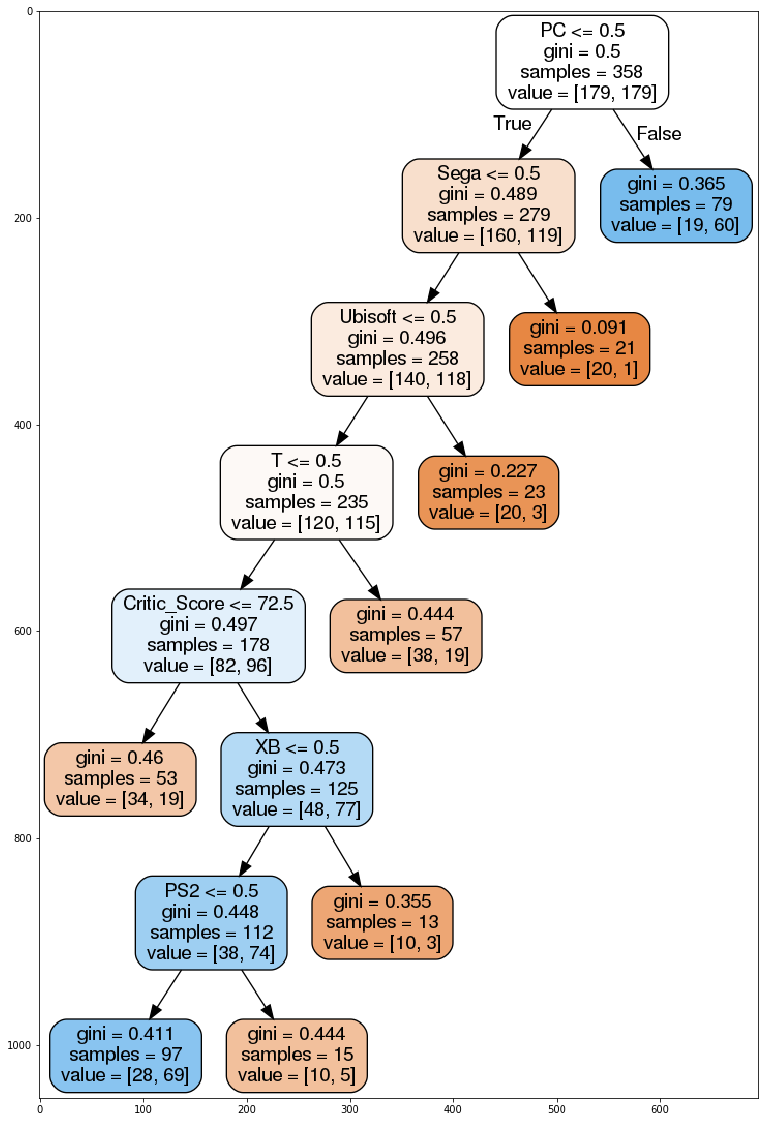

In [15]:
show_tree(dt14, features, 'arbol_subsampled.png')

Árbol con Oversampling y Subsampling:

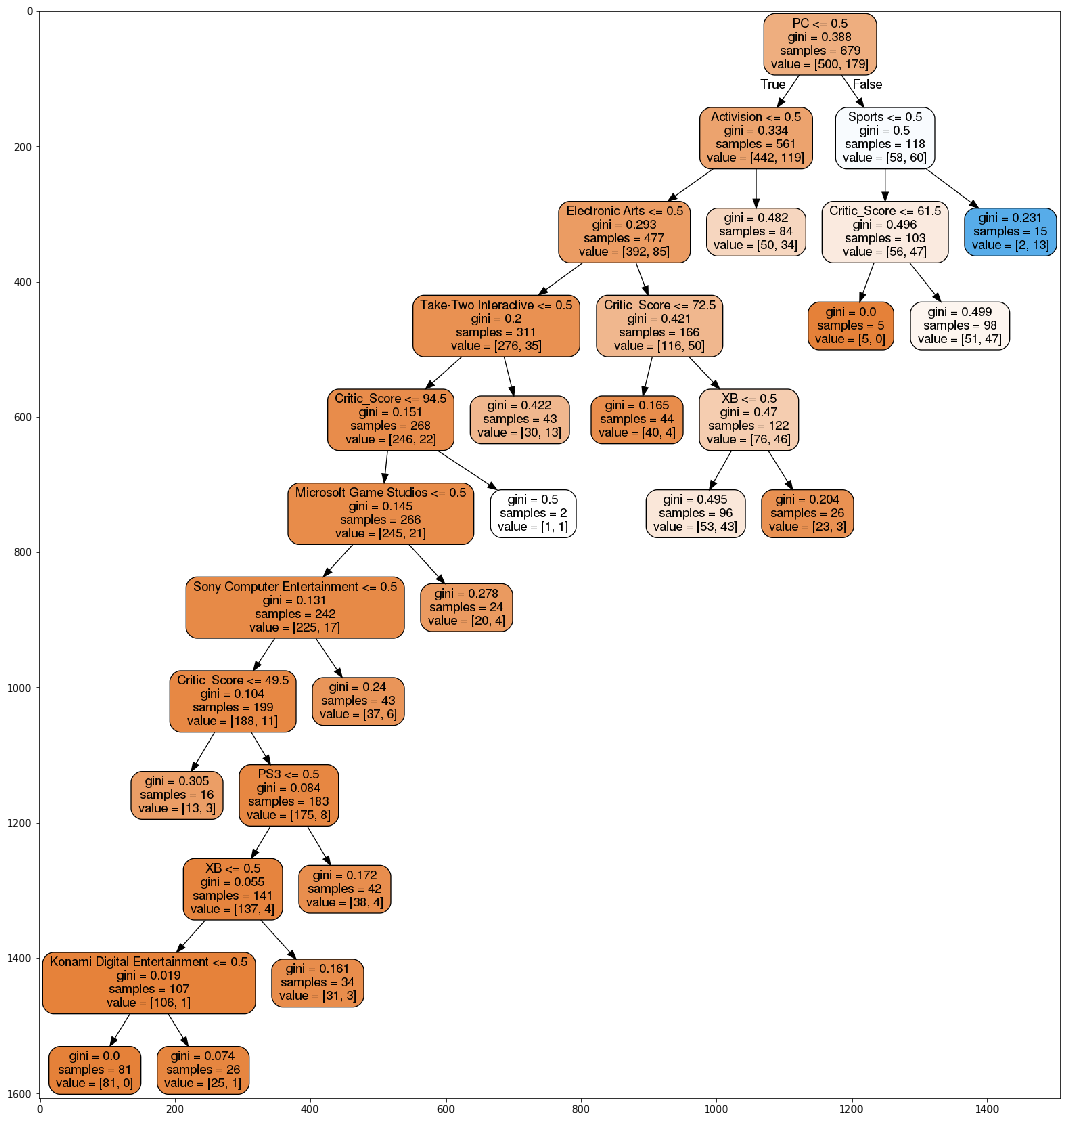

In [16]:
show_tree(dt15, features, 'arbol_master.png')

# 6 - Random Forest
Se aplica Random Forest para obtener los atributos que tienen mayor importancia en los árboles de decisión.

In [17]:

clf6 = RandomForestClassifier(n_estimators= 1000,max_depth=100, random_state=0)
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]
clf6.fit(X_train, y_train)
import operator
mi_lista_de_tuplas = []
for i in range(33):
    tupla = (header[i],clf6.feature_importances_[i])
    mi_lista_de_tuplas.append(tupla)
mi_lista_de_tuplas.sort(key=operator.itemgetter(1), reverse=True)
for i in range(33):
    print(mi_lista_de_tuplas[i])

('Critic_Score', 0.4809247003057201)
('Activision', 0.039060302382216076)
('PC', 0.03782509809279979)
('Action', 0.03231123679775759)
('Sports', 0.031025745015739327)
('Electronic Arts', 0.02849756124568838)
('PS3', 0.027579626813388238)
('E', 0.027469574794272426)
('T', 0.02339539453109587)
('X360', 0.022582316881312736)
('Racing', 0.020496221730503566)
('M', 0.020151401872263976)
('PS2', 0.019963803332216548)
('XB', 0.01978029373739758)
('E10+', 0.018716281176629206)
('Take-Two Interactive', 0.018173772427965616)
('Shooter', 0.014174363773424885)
('Konami Digital Entertainment', 0.012721758781949581)
('Ubisoft', 0.01255964928873499)
('Role-Playing', 0.012189647784758185)
('Sega', 0.010598894039975168)
('Sony Computer Entertainment', 0.010077685222713106)
('Microsoft Game Studios', 0.009836420078638426)
('THQ', 0.009432977567155084)
('Platform', 0.00892188488036117)
('Simulation', 0.008787601202762315)
('Misc', 0.006886512923645094)
('Strategy', 0.005006232261273291)
('Namco Bandai Ga